In [23]:
# Supress pytorch pickle load warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# Library imports
import gdiffusion as gd
import util
import util.chem as chem
import util.visualization as vis
import util.stats as gdstats


import gdiffusion.bayesopt as bayesopt
from gdiffusion.classifier.logp_predictor import LogPPredictor
from gdiffusion.classifier.extinct_predictor import EsmClassificationHead

device = util.util.get_device()
print(f"device: {device}")

DIFFUSION_PATH = "saved_models/diffusion/molecule-diffusion-v1.pt"
SELFIES_VAE_PATH = "saved_models/selfies_vae/selfies-vae.ckpt"
SELFIES_VAE_VOCAB_PATH = "saved_models/selfies_vae/vocab.json"

PEPTIDE_VAE_PATH = "saved_models/peptide_vae/peptide-vae.ckpt"
PEPTIDE_VAE_VOCAB_PATH = "saved_models/peptide_vae/vocab.json"

LOGP_PREDICTOR_PATH = "saved_models/logp/model-logp"
EXTINCT_PREDICTOR_PATH = "saved_models/extinct_model8417"

device: cuda


In [ ]:
diffusion = gd.create_peptide_diffusion_model(model_path=DIFFUSION_PATH, device=device)
selfies_vae = gd.load_vae_selfies(path_to_vae_statedict=SELFIES_VAE_PATH, vocab_path=SELFIES_VAE_VOCAB_PATH)
peptide_vae = gd.load_vae_peptides(path_to_vae_statedict=PEPTIDE_VAE_PATH, vocab_path=PEPTIDE_VAE_VOCAB_PATH)

extinct_predictor : EsmClassificationHead = torch.load(EXTINCT_PREDICTOR_PATH, weights_only=False).to(device)
logp_predictor : LogPPredictor = torch.load(LOGP_PREDICTOR_PATH, weights_only=False).to(device)


Model created successfully
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB
- Device: cuda:0
- Model Name: LatentDiffusionModel
loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346
loading model from saved_models/peptide_vae/peptide-vae.ckpt
Enc params: 2,675,904
Dec params: 360,349


In [30]:
z_diffusion_cached = diffusion.sample(batch_size=64)

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 43.32it/s]


In [31]:
# Diffusion Test #1
# Goal is to get the latent space z to be as close to the distribution below:

mean = -0.5, sigma = 0.01
cond_fn_normal_dist = gd.get_cond_fn_normal_analytical(mean=mean, sigma=sigma)

z = diffusion.sample(batch_size=16, cond_fn=cond_fn_normal_dist)
gdstats.is_different_from_other(z, z_diffusion_cached, alpha=0.01, do_print=True)
vis.display_latent(z[0])
print(f"Min Value: {z[0].min():.2f}")
print(f"Max Value: {z[0].max():.2f}")
print(f"Mean Value: {z[0].mean():.2f}")
print(f"STD Deviation: {z[0].std():.2f}")



SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (792460642.py, line 4)

DDPM Sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 40.74it/s]


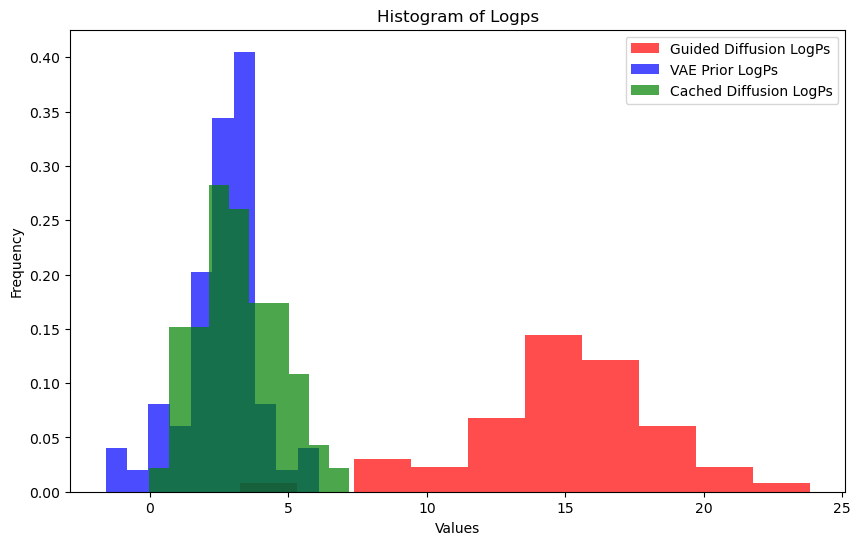

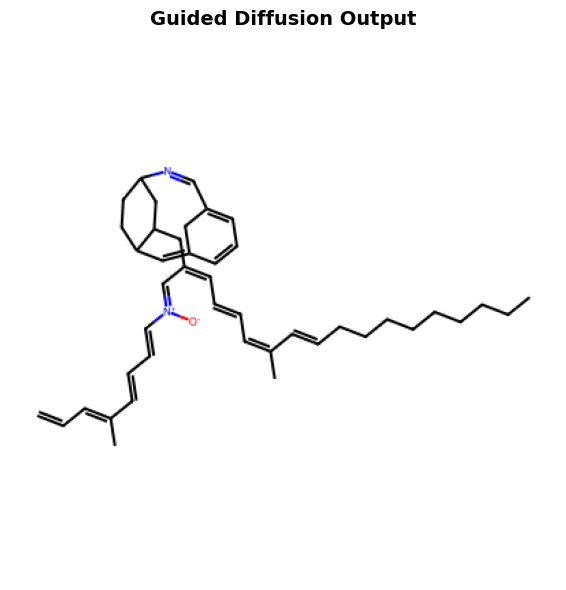

SMILES: CCCCCCCCCC=CC(C)=CC=CC=C(C=[N+1]([O-1])C=CC=CC(C)=CC=C)CC1CC2CCC1C=C3C=CC=C(C3)C=N2
LogP Stats: 
Max LogP: 23.840100000000024
Min LogP: 3.2399000000000022
Avg LogP: 15.043648437499977

Stats:
Sample of shape: torch.Size([64, 1, 128]) is different from other with p=0.0000

Minimum VAE Value: -5.345076084136963
Maximum VAE Value: 4.231697082519531


In [ ]:
# Diffusion Test #2 and #3
# The goal is to get the shapes to work (this is just a shape test)

logp_distribution = Normal(loc=100.0, scale=1.0)

# log probability function that gives the probability of the logps of z
# under the logp_distribution

def log_prob_fn_logp(z):
    # We cant backprop thru the evaluate_logp function, so we 
    # instead have this predictor trained on latent, logp pairs:
    pred_logp = logp_predictor(z)

    # get the log_probability under the normal distribution with mean=20.0
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

    # the log probability must be a single value
    assert(log_prob.shape == (1, ))
    return log_prob


# Pass random data through to check shapes work
z_random = torch.randn(16, 1, 128, device=device)

cond_fn_logp = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    guidance_strength=1.0, 
    clip_grad=True, 
    clip_grad_max=1.0,
)

grad_log_prob = cond_fn_logp(mean = z_random, t = 0)
assert(z_random.shape == grad_log_prob.shape)

# Diffusion Test #3
# Try and guide the diffusion to a high LogP molecule:
z = diffusion.sample(batch_size=64, cond_fn=cond_fn_logp)
vis.display_logp_info(z, z_diffusion_cached=z_diffusion_cached, vae=selfies_vae)

print(f"Minimum VAE Value: {z.flatten().min():.2f}")
print(f"Maximum VAE Value: {z.flatten().max():.2f}")


In [ ]:
# Bayesopt Guided diffusion

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qLogExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models import SingleTaskGP
from botorch.utils.transforms import normalize, unnormalize
from torch.optim import SGD


In [30]:

LATENT_DATASET_LOCATION = "data/latents_pair_dataset_1"
LOGP_LABEL_DATASET_LOCATION = "data/logp_pair_dataset_1"

X_all_data = torch.load(LATENT_DATASET_LOCATION, weights_only=True)
Y_all_data = torch.load(LOGP_LABEL_DATASET_LOCATION, weights_only=True)

def get_initial_data(num_initial_datapoints=100):
    Xs = X_all_data[:num_initial_datapoints].reshape(-1,128).clone().double().to(device)
    Ys = Y_all_data[:num_initial_datapoints].reshape(-1,1).clone().double().to(device)
    return Xs, Ys

In [ ]:
# Initialize Bayesopt model:
d = 128
x_min, x_max = -3.0, 3.0
bounds = torch.tensor([[x_min] * d, [x_max] * d], device=device, dtype=torch.double)
vae = selfies_vae.double().to(device)

def get_logp(z):
    z_unorm = unnormalize(z, bounds=bounds)
    Y_next_list = chem.latent_to_logp(z_unorm, vae=vae)
    Y_next = torch.tensor(Y_next_list, dtype=model.train_targets.dtype, device=device).reshape(-1, 1)
    return Y_next


def normalize_x(X, bounds, device=device):
    x_min, x_max = bounds[0][0].item(), bounds[1][0].item()
    d = bounds[0].shape[0]

    X = X.reshape(-1, d).double().to(device)
    X = torch.clip(X, min=x_min, max=x_max)
    X = normalize(X, bounds=bounds)
    return X

def fit_model(model, mll, optimizer, num_epochs=10, show_epoch_num=False):
    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        loss = -mll(output, model.train_targets)
        loss.backward()

        if (epoch + 1) % 10 == 0 and show_epoch_num:
            print(f"Epoch {epoch+1:>3}/{num_epochs} - Loss: {loss.item():>4.3f} ")
        
        optimizer.step()
    print(f"Final Loss: {loss.item():.3f}")
    
def generate_batch(ei, d=128, batch_size=10, num_restarts=5, raw_samples=128, sequential=True):
    unit_bounds = torch.tensor([[0.0] * d, [1.0] * d], device=device, dtype=torch.float64)
    X_next, acq_value = optimize_acqf(
        ei,
        q=batch_size,
        bounds=unit_bounds,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        sequential=sequential
    )
    
    return X_next

X_init_unnorm, Y_init = get_initial_data(num_initial_datapoints=1000)
X_init = normalize_x(X_init_unnorm, bounds, device=device)

model = SingleTaskGP(train_X=X_init, train_Y=Y_init)
optimizer = SGD([{"params": model.parameters()}], lr=0.025)

mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_model(model, mll, optimizer, num_epochs=1)


Final Loss: 2.758


In [149]:
for batch in range(100):
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_model(model, mll, optimizer, num_epochs=10)

    ei = qLogExpectedImprovement(model, best_f=Y.max())
    X_next = generate_batch(ei, batch_size=5, num_restarts=10, raw_samples=512, sequential=False)

    # convert latent to logp
    Y_next = get_logp(z=X_next)
    model = model.condition_on_observations(X_next, Y_next)

    # Print
    y_raw = model.outcome_transform.untransform(model.train_targets.max())[0].item()
    x_iter = len(model.train_inputs[0])
    print(f"{len(model.train_inputs[0])}) Best value: {y_raw:.4f}")


Final Loss: 1.705
1005) Best value: 11.2270
Final Loss: 1.721
1010) Best value: 11.2270
Final Loss: 1.718
1015) Best value: 15.8316
Final Loss: 1.718
1020) Best value: 15.8316
Final Loss: 1.725


OutOfMemoryError: CUDA out of memory. Tried to allocate 514.00 MiB. GPU 0 has a total capacity of 7.63 GiB of which 152.25 MiB is free. Including non-PyTorch memory, this process has 7.46 GiB memory in use. Of the allocated memory 4.43 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
vae = selfies_vae
# ~100 data points to initialize
vae = vae.double().to(device)
# obj_func = lambda smiles : calculate_logp(smiles, invalid_token=0.0)

d = 128
bounds = torch.tensor([[-3.0] * d, [3.0] * d], device=device, dtype=torch.float64)
unit_bounds = torch.tensor([[0.0] * d, [1.0] * d], device=device, dtype=torch.float64)

class BayesOptModel:
    def __init__(self, is_normalized=True):
        self.X, self.Y = get_initial_data()
        self.X = torch.clip(self.X, min=-3.0, max=3.0)
        self.is_normalized = is_normalized
        if self.is_normalized:
            self.X = normalize(self.X, bounds=bounds)


        self.state_dict = None
        self.model = self.get_model()

        self.optimizer = SGD([{"params": self.model.parameters()}], lr=0.025)

    def get_model(self):
        '''User-defined function which defines the model'''
        return SingleTaskGP(train_X=self.X, train_Y=self.Y)
    
    def get_ei(self):
        '''User-defined function which defines the EI function'''
        return qLogExpectedImprovement(self.model, best_f=self.Y.max())

    def get_mll(self):
        '''User-defined function which defines the MLL function'''
        return ExactMarginalLogLikelihood(self.model.likelihood, self.model)
    
    def fit_inital(self, num_epochs=100):
        self._fit_model(num_epochs=num_epochs)
        self.state_dict = self.model.state_dict()

    def train(self, num_epochs=300, initial_fit_num_epochs=250, model_fit_num_epochs=10, acqf_batch_size=10, acqf_num_restarts=5, acqf_raw_samples=128, acqf_sequential=True):
        # initial fitting
        self.fit_inital(initial_fit_num_epochs)
        
        for epoch in range(num_epochs):
            self.model = self.get_model()

            if self.state_dict is not None:
                self.model.load_state_dict(self.state_dict)

            self._fit_model()
            X_next = self._generate_batch(batch_size=acqf_batch_size, num_restarts=acqf_num_restarts, raw_samples=acqf_raw_samples, sequential=acqf_sequential)

            X_next_unormalized = unnormalize(X_next, bounds=bounds) if self.is_normalized else X_next
            Y_next_list = chem.latent_to_logp(X_next_unormalized, vae=vae)
            Y_next = torch.tensor(Y_next_list, dtype=self.Y.dtype, device=device).reshape(-1, 1)

            self.X = torch.cat([self.X, X_next])
            self.Y = torch.cat([self.Y, Y_next])

            self.state_dict = self.model.state_dict()


            print(f"{len(self.X)}) Best value: {self.Y.max():.5f}")

    def _fit_model(self, num_epochs=10, show_epoch_num=False):
        mll = self.get_mll()
        self.model.train()

        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            output = self.model(self.X)
            loss = -mll(output, self.model.train_targets)
            loss.backward()

            if (epoch + 1) % 10 == 0 and show_epoch_num:
                print(f"Epoch {epoch+1:>3}/{10} - Loss: {loss.item():>4.3f} ")

            self.optimizer.step()

    def _update_model(self):
        pass

    def _generate_batch(self, batch_size=10, num_restarts=10, raw_samples=512, sequential=True):
        print("Generating Batch...")
        ei = self.get_ei()

        acqf_bounds = unit_bounds if self.is_normalized else bounds
        X_next, acq_value = optimize_acqf(
            ei,
            q=batch_size,
            bounds=acqf_bounds,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            sequential=sequential
        )
        
        return X_next
bayesopt = BayesOptModel()
bayesopt.train()


Generating Batch...
110) Best value: 19.83650
Generating Batch...
120) Best value: 21.24500
Generating Batch...
130) Best value: 21.24500
Generating Batch...
140) Best value: 21.24500
Generating Batch...
150) Best value: 21.24500
Generating Batch...
160) Best value: 21.24500
Generating Batch...
170) Best value: 21.24500
Generating Batch...
180) Best value: 21.24500
Generating Batch...
190) Best value: 21.24500
Generating Batch...
200) Best value: 21.24500
Generating Batch...
210) Best value: 21.73450
Generating Batch...
220) Best value: 21.73450
Generating Batch...
230) Best value: 21.73450
Generating Batch...
240) Best value: 21.73450
Generating Batch...
250) Best value: 22.80850
Generating Batch...
260) Best value: 22.80850
Generating Batch...
270) Best value: 22.80850
Generating Batch...
280) Best value: 22.80850
Generating Batch...
290) Best value: 22.80850
Generating Batch...
300) Best value: 23.90970
Generating Batch...
310) Best value: 27.31380
Generating Batch...
320) Best valu

[14:12:30] Explicit valence for atom # 8 Se, 7, is greater than permitted


Error: Invalid SMILES string 'CNC(O)CCCN=[Se](CCCS)(=O)=O'
610) Best value: 42.68970
Generating Batch...
620) Best value: 42.68970
Generating Batch...
630) Best value: 42.68970
Generating Batch...
640) Best value: 42.68970
Generating Batch...
650) Best value: 42.68970
Generating Batch...
660) Best value: 42.68970
Generating Batch...
670) Best value: 42.68970
Generating Batch...
680) Best value: 42.68970
Generating Batch...
690) Best value: 42.68970
Generating Batch...
700) Best value: 42.68970
Generating Batch...
710) Best value: 42.68970
Generating Batch...
720) Best value: 42.68970
Generating Batch...
730) Best value: 42.68970
Generating Batch...
740) Best value: 42.68970
Generating Batch...
750) Best value: 42.68970
Generating Batch...
760) Best value: 42.68970
Generating Batch...
770) Best value: 42.68970
Generating Batch...
780) Best value: 42.68970
Generating Batch...
790) Best value: 42.68970
Generating Batch...
800) Best value: 42.68970
Generating Batch...
810) Best value: 42.6

OutOfMemoryError: CUDA out of memory. Tried to allocate 232.00 MiB. GPU 0 has a total capacity of 7.63 GiB of which 78.25 MiB is free. Including non-PyTorch memory, this process has 7.54 GiB memory in use. Of the allocated memory 4.97 GiB is allocated by PyTorch, and 2.37 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)